# Simple Single Object Detection - A Naive Approach

**_Experimenting with a single object detection using subset of Caltech-101 dataset and transfer learning._**

In this experiment, images of airplanes with thier bounding boxes are extracted from Caltech-101 dataset and then trained on a MobileNetV2 pretrained model with customization to detect the location of airplanes in new images.

**The Experiment:**

- Downloads Caltech-101 dataset (caltech-101.zip) from https://data.caltech.edu/records/mzrjq-6wc02. This dataset has pictures of objects belonging to 101 categories each containing about 40 to 800 images. The size of each image is roughly 300 x 200 pixels. The annotations stored as MATLAB script file (.mat) contain outlines (bounding box) of each object in these pictures.

- Extracts the dataset from the downloaded compressed file caltech-101.zip.

- Sets the root paths for airplanes images and and annotations.

- Loads the data (image path and respective bounding boxes) into an intermediate datastructure by reading bounding boxes from MATLAB .mat annotation file and rescaling the boxes.

- Writes helper functions to show images and to draw bounding boxes.

- Samples randomly from the metadata and check visually if the above two helper functions work.

- Uses a lightweight relevant pretrained model e.g. MobileNetV2 excluding the top layers used for ImageNet classification task. Add task specific top layers.

- Uses an data loader such as TensorFlow Dataset to serve data efficiently while model training.

- Seperates validation set froom training set.

- Compiles and fit the model with early stopping.

- Plots the learning curve.

- Performs predictions on validation data and visualize these by plotting both images and associated predicted bounding boxes.

## Importing Packages

In [1]:
import os                                           # For file system related tasks
import urllib.request as request, zipfile, tarfile  # For downloading file from Internet and extractions   
import random
from scipy.io import loadmat                        # For reading MATLAB (.mat) files
from PIL import Image                               # For reading image files
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle            # Drawing rectangle shape on on plots

import tensorflow as tf

2026-01-12 03:48:57.990009: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-12 03:48:58.043986: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-12 03:48:59.349139: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Data Ingestion

**Downloading Data Files**

In [2]:
url = "https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip"

# Creates dataset directory, if does not exist. 
# Set the path according to you preference or based on the directory the data already exists.
data_dir = "./data/caltech-101"

os.makedirs(data_dir, exist_ok=True)

data_file_name = "caltech-101.zip"
data_file_path = os.path.join(data_dir, data_file_name)

In [3]:
# Downloads data file only if it does not exist

# UNCOMMENT THE FOLLOWING LINES AND RUN ONLY IF THE EXTRACTED DATASET IS NOT AVAILABLE. 
# CHECK WITH THE INSTRUCTOR FIRST.

if not os.path.isfile(data_file_path):
     print(f"Data file {data_file_path} could not be found. Downloading...", end="")
     try:
         request.urlretrieve(url, data_file_path)
         print("successful.")
     except Exception as e:
         print(f"An error occurred while downloading: {e}")
else:
     print("Image file already exists. Downloading was skipped.")


Image file already exists. Downloading was skipped.


**Decompressing Data File**

In [4]:
# Decompresses images file

# UNCOMMENT THE FOLLOWING LINES AND RUN ONLY IF THE EXTRACTED DATASET IS NOT AVAILABLE. 
# CHECK WITH THE INSTRUCTOR FIRST.

if os.path.isfile(data_file_path):
     print(f"Decompressing {data_file_path}...", end="")
     try:
         with zipfile.ZipFile(data_file_path, "r") as zipped:
             zipped.extractall(data_dir)
         print("successful.")
#         # Decompressing images tar file
         images_tarfile_path = os.path.join(data_dir, "caltech-101", "101_ObjectCategories.tar.gz")
         print(f"Decompressing {images_tarfile_path}...", end="")
         try:
             with tarfile.open(images_tarfile_path, "r:gz") as tar:
                 tar.extractall(os.path.join(data_dir, "caltech-101"), filter="data")
             print("successful.")
         except Exception as e:
             print(f"An error occurred while decompressing: {e}")
         finally:
             tar.close()

         # Decompressing annotations tar file
         annotations_tarfile_path = os.path.join(data_dir, "caltech-101", "Annotations.tar")
         print(f"Decompressing {annotations_tarfile_path}...", end="")
         try:
             with tarfile.open(annotations_tarfile_path, "r") as tar:
                 tar.extractall(os.path.join(data_dir, "caltech-101"), filter="data")
             print("successful.")
         except Exception as e:
             print(f"An error occurred while decompressing: {e}")
         finally:
             tar.close()
       
     except Exception as e:
         print(f"An error occurred while decompressing: {e}")
else:
     print(f"File {data_file_path} does not exist. Decompression was skipped.")

Decompressing ./data/caltech-101/caltech-101.zip...successful.
Decompressing ./data/caltech-101/caltech-101/101_ObjectCategories.tar.gz...successful.
Decompressing ./data/caltech-101/caltech-101/Annotations.tar...successful.


## Data Preparation

Rename the following annotations folders as there are mismatches between images and annotations folder names.

- Airplanes_Side_2 to airplanes
- Faces_2 to Faces
- Faces_3 to Faces_easy
- Motorbikes_16 to Motorbikes

In [12]:
# Sets the root paths for airplanes images and and annotations.
images_dir = os.path.join(data_dir, "caltech-101", "101_ObjectCategories", "airplanes")
annotations_dir = os.path.join(data_dir, "caltech-101", "Annotations", "airplanes")

In [14]:
def scale_box(box, image_width, image_height):
    """
    Scales the bounding box on a unit square and converts box from
    the format [y1, y2, x1, x2] to [x1, y1, width, height]
    """

    box = [box[2], box[0], box[3]-box[2], box[1]-box[0]]

    # Write code to scale down the variables in the bounding box in a unit scale based on the 
    # maximum length of either image width or height.
    scale = 1.0 / max(image_width, image_height)
    x, y, w, h = [v * scale for v in box]


    ## Center aligns starting coordinates
    x += (image_height - image_width) * scale / 2 if image_height > image_width else 0
    y += (image_width - image_height) * scale / 2 if image_width > image_height else 0
    
    return [x, y, w, h]

In [15]:
metadata = {}  # An intermediate data structure to hold meta information about the images and respective bounding boxes

id = 0         # Simple counter to act as key to the metadata dictionary

for file in os.listdir(images_dir):             # Iterates over the files in the airplane image folder
   image_path = os.path.join(images_dir, file)  # Gets a path to the file for image loading
   base_name = os.path.splitext(file)[0]        # Gets base name of image file [e.g. ../airplanes/image_0616.jpg to image_0616] to prepare path for associated .mat file
   annotation_file = os.path.join(data_dir, "caltech-101", "Annotations", "airplanes", f"annotation_{base_name[-4:]}.mat")    # Gets path to annoation (.mat) file
   if os.path.exists(annotation_file):          # Skips if the associated annotation file does not exist
      metadata[id] = id                         # Sets the key against this meta information for later retrieval
      mat_contents = loadmat(annotation_file)   # Reads the content from the .mat file
      with Image.open(image_path) as image:     # Loads the image to get image width and height to scale the bounding box accordingly
         scaled_box = scale_box(mat_contents['box_coord'][0].tolist(), image.width, image.height)  # Scales the bounding box in a unit square
      metadata[id] = {"box": scaled_box, "image_path": image_path}   # Stores the information in the intermediate data structure
      id += 1                                   # Increment the counter
   else:
         print(f"Not found: {annotation_file}") # Prints of an associated annotation file against an image file does not exist

In [16]:

# Write code to get a random from the metadata to check
metadata[0]


{'box': [0.12311557788944724,
  0.3693467336683417,
  0.7537688442211056,
  0.26884422110552764],
 'image_path': './data/caltech-101/caltech-101/101_ObjectCategories/airplanes/image_0001.jpg'}

In [18]:
def draw_image(ax, image):
    """
    Draws the image on a unit cube with (0, 0) at the top left
    """
    ax.set(xlim=(0, 1), ylim=(1, 0), xticks=[], yticks=[], aspect="equal")
    image = plt.imread(image)           # Reads the image from its path
    height, width = image.shape[:2]     # Gets the image's height and width by reading first two dimention (considering the 3rd dimension is used for channels)
    
    # Pads the image so it fits inside the unit cube
    hpad = (1 - height / width) / 2 if width > height else 0
    wpad = (1 - width / height) / 2 if height > width else 0
    extent = [wpad, 1 - wpad, 1 - hpad, hpad]
    
    ax.imshow(image, extent=extent) 

In [19]:
def draw_box(ax, box, color):
    """
    Draws bounding box of a specific linewidth (lw), (edge) color (ec)
    """
    x, y, w, h = box
    ax.add_patch(Rectangle((x, y), w, h, lw=2, ec=color, fc="none"))    # Draws the bounding box as rectangle with no filling color (fc)

In [20]:

def draw_prediction(image, predicted_box):
    """
    Draws the both image and predicted bounding box on a unit cube with (0, 0) at the top left
    utilising helper functions `draw_image()` and `draw_box()`.
    """
    fig, ax = plt.subplots(dpi=150)
    draw_image(ax, image)               # First draws the image containg object for which bounding box is to be predicted
    draw_box(ax, predicted_box, "r")    # Then draws predicted bounding box
    
    plt.show()

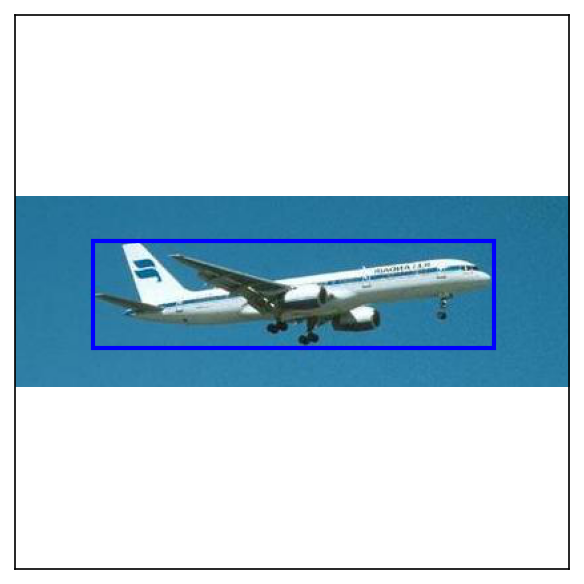

In [21]:

# Sample randomly from the metadata and check visually if the above two helper functions work

random_sample_id = random.randint(0, len(metadata)-1)
sample = metadata[random_sample_id]

ig, ax = plt.subplots(dpi=150)
draw_image(ax, sample["image_path"])
box = sample["box"]
draw_box(ax, box, 'b')
plt.show()

In [22]:
# Finally shuffles the stored information before preparing data set for modeling
random.shuffle(metadata)

## Modeling

In [23]:
# Uses a particular images size for which the target pretrained model (refer below) offers optimized model weights
image_size = 160

In [24]:
# Instantiates the MobileNetV2 architecture and returns a an image classification model loaded with weights pre-trained on ImageNet.
# Refer more details at https://keras.io/api/applications/mobilenet/#mobilenetv2-function
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(image_size, image_size, 3),
    include_top=False,          # Excludes imagenet specific top layer
    weights="imagenet",         # Loads weights of model pretrained on "imagenet" dataset
)

base_model.trainable = False    # Sets the base model parameters non-trainable

2026-01-12 03:57:17.202094: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [25]:
# Creates model out of base model

inputs = tf.keras.Input(shape=(image_size, image_size, 3))          # Defines the model input with shape expectation
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)     # Scales input pixels between -1 and 1 before passing them to the model.
x = base_model(x)                                                   # Sets base_model in inference mode here

# Makes basemodel outputs smaller and then flattens the output features
x = tf.keras.layers.Conv2D(512, (3, 3), strides=(2, 2))(x)          # Further convolve the spatial dimension of base-model's output
x = tf.keras.layers.Flatten()(x)                                    # Flattens convolutional layer's 3-D output (feature maps) into 1-D

# Passes our flattened data through three densely connected layers
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)

# Outputs 4 units (start coordinates (x, y), width and height) each with sigmoid activation to
# ensure outputs range between 0 and 1 to scale later.
head = tf.keras.layers.Dense(4, activation="sigmoid")(x)

model = tf.keras.Model(inputs=inputs, outputs=head)                 # Creates target model combining inputs and outputs

In [26]:
# Checks the model summary before proceeding for model training
# Ensure non-trainable weights shown in red for locked base model.
model.summary(show_trainable=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 160, 160, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ true_divide (TrueDivide)    │ (None, 160, 160, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ subtract (Subtract)         │ (None, 160, 160, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mobilenetv2_1.00_160        │ (None, 5, 5, 1280)    │  2,257,984 │   N   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d (Conv2D)             │ (None, 2, 2, 512)     │  5,898,752 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten (Flatten)           │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 128)           │    262,272 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 64)            │      8,256 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 32)            │      2,080 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_3 (Dense)             │ (None, 4)             │        132 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 8,429,476 (32.16 MB)

 Trainable params: 6,171,492 (23.54 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [27]:
# Efficient data loader to serve data efficiently while model training

resizer = tf.keras.layers.Resizing(image_size, image_size)      # A function to make the size of all input images same


def load_image(path):
    """
    Loads and resizes an input image from its path
    """
    x = tf.io.read_file(path)
    x = tf.image.decode_jpeg(x, channels=3)
    return resizer(x)

# First loads path for all images into TensorFlow Dataset and then
# loads the images against each of the image path
images = tf.data.Dataset.from_tensor_slices([v["image_path"] for v in metadata.values()])
images = images.map(load_image, num_parallel_calls=8)

# Similarly, loads the bounding box for all images
labels = tf.data.Dataset.from_tensor_slices([v["box"] for v in metadata.values()])

# Combines these two dataset into one
dataset = tf.data.Dataset.zip(images, labels)

# Seperates out 20% of samples as validation set, and then
# sets batch size and enables prefetching for each of the datasets
val_set = dataset.take(160).batch(32).prefetch(2)
train_set = dataset.skip(160).batch(32).prefetch(2)

## Training the Model

In [28]:
# Compiles the model with Adam optimizer with learning rate 1e-4 and "mse" as loss function
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="mse",
)

# Fits the model train and validation set, `epochs` as 50 and 
# callbacks with EarlyStopping with 10 as `patience`, "val_loss" as `monitor`, "min" as `mode` and setting "True" to `restore_best_weights`
history = model.fit(train_set, validation_data=val_set,
                    epochs=50, callbacks=[
                        tf.keras.callbacks.EarlyStopping(
                            monitor="val_loss", patience=10, mode="min", restore_best_weights=True)])

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 354ms/step - loss: 0.0150 - val_loss: 0.0041
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 309ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 307ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 313ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 306ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 307ms/step - loss: 8.2306e-04 - val_loss: 0.0019
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 307ms/step - loss: 7.1584e-04 - val_loss: 0.0022
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 305ms/step - loss: 6.0337e-04 - val_loss: 0.0021
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 307ms/step - loss: 6.4647e-04 - val_loss: 0.0021
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 303ms/step - loss: 6.7813e-04 - val_loss: 0.0022
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 307ms/step - loss: 7.5893e-04 - val_loss: 0.0020
Epoch 12/50
20/20 ━━━━━━━━━

Text(0.5, 1.0, 'Learning Curves')

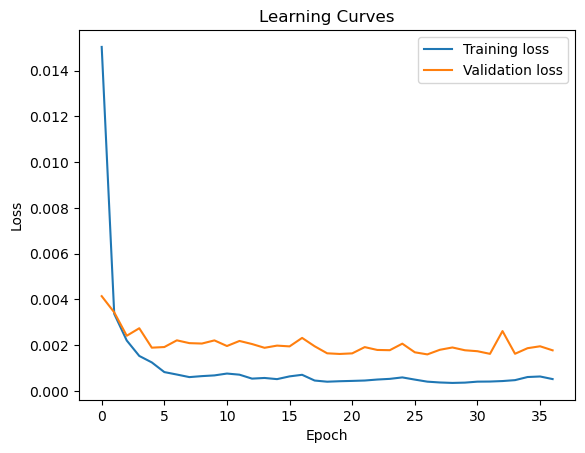

In [29]:
# Plots the learning curve

plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Learning Curves")

In [30]:
# Performs predictions on the validation data
val_predictions = model.predict(val_set)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step


In [31]:
# Checks one of the predictions to ensure 
val_predictions[0]

array([0.13717665, 0.4040313 , 0.74665964, 0.22189547], dtype=float32)

Image path: ./data/caltech-101/caltech-101/101_ObjectCategories/airplanes/image_0092.jpg


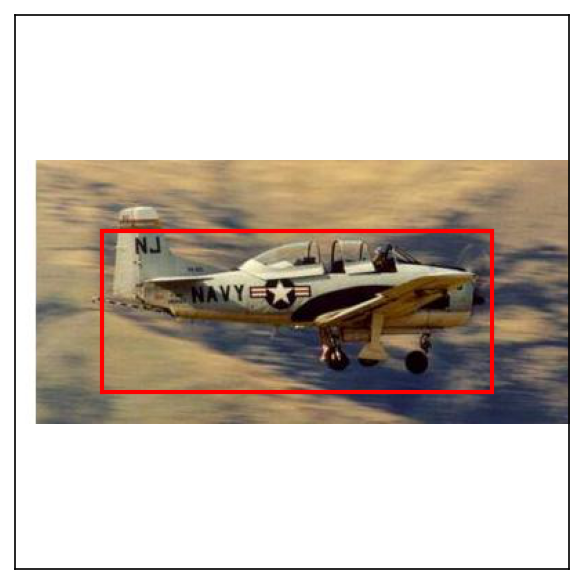

In [32]:
# Visualizes the predicted bounding boxes of any random image from validation set
# [Note: Run this cell multiple time to check predictions against different samples]

random_sample_id = random.randint(0, 160-1)

predicted_box = val_predictions[random_sample_id]

image_path = metadata[random_sample_id]["image_path"]   # Gets the image file path from metadata as it was not required to be stored in TensorFlow Dataset for modeling

print(f"Image path: {image_path}")
draw_prediction(image_path, predicted_box)


## Observations

- How was the subset prepared for both images and its annotations to make it ready for model training?

- Why was an intermediate data structure prepared to store dataset, and how was the structure like and what did it contain?

- Which helper functions were created and why were they created for?

- Why was a pretrained model used as a base model? How was a custom model built on top of it?

- Which data loader was used to load the data to fed into model for training? Why was an data loader used instead of manually fed the data into model for training? Why was early stopping used and how it was configured?

- Explain the learning curve.